# Experiment 1 -- 50 pairs of untrained models, dummy data 

In [1]:
#checking mean and similarity on 50 random models (mlp). 
# Here we use dummy data to evaluate gradient similarity. 

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

# Import the MNIST model from models.py
from models import MNISTNet

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to initialize a model with a given seed
def init_model(seed):
    torch.manual_seed(seed)
    return MNISTNet().to(device)

# Function to calculate gradient similarity between two models
def calculate_gradient_similarity(model1, model2):
    # Create dummy data
    dummy_input = torch.randn(100, 3, 28, 28).to(device)
    dummy_target = torch.randint(0, 10, (100,)).to(device)
    
    criterion = nn.CrossEntropyLoss(reduction='none')
    
    # Calculate gradients
    grad1 = get_gradients_simple(dummy_input, dummy_target, model1, criterion)
    grad2 = get_gradients_simple(dummy_input, dummy_target, model2, criterion)
    
    # Calculate similarity
    similarity = np.dot(grad1, grad2) / (np.linalg.norm(grad1) * np.linalg.norm(grad2))
    
    return similarity

def get_gradients_simple(X, y, model, criterion):
    model.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y).mean()  # Use mean reduction
    loss.backward()
    
    grad_list = []
    for name, p in model.named_parameters():
        if p.grad is not None:
            grad_list.append(p.grad.detach().cpu().numpy().flatten())
    
    return np.concatenate(grad_list)

# Run the experiment
n_pairs = 50
similarities = []

for i in range(n_pairs):
    model1 = init_model(seed=i)
    model2 = init_model(seed=i+n_pairs)
    
    similarity = calculate_gradient_similarity(model1, model2)
    similarities.append(similarity)

# Calculate statistics
mean_similarity = np.mean(similarities)
std_similarity = np.std(similarities)

print(f"Mean gradient similarity: {mean_similarity:.4f}")
print(f"Standard deviation of gradient similarity: {std_similarity:.4f}")

Mean gradient similarity: 0.0263
Standard deviation of gradient similarity: 0.0190


# Experiment 2 -- 50 pairs of untrained models, MNIST data 

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

# Import the MNIST model from models.py
from models import MNISTNet

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to initialize a model with a given seed
def init_model(seed):
    torch.manual_seed(seed)
    return MNISTNet().to(device)

def gray_to_rgb(img):
    return img.repeat(3, 1, 1)

def load_mnist_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(gray_to_rgb),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=len(trainset), shuffle=False)
    
    # Get the full dataset in one batch
    inputs, targets = next(iter(trainloader))
    return inputs.to(device), targets.to(device)

# Function to calculate gradient similarity between two models
def calculate_gradient_similarity(model1, model2, inputs, targets):
    criterion = nn.CrossEntropyLoss(reduction='none')
    
    # Calculate gradients
    grad1 = get_gradients_simple(inputs, targets, model1, criterion)
    grad2 = get_gradients_simple(inputs, targets, model2, criterion)
    
    # Calculate similarity
    similarity = np.dot(grad1, grad2) / (np.linalg.norm(grad1) * np.linalg.norm(grad2))
    
    return similarity

def get_gradients_simple(X, y, model, criterion):
    model.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y).mean()  # Use mean reduction
    loss.backward()
    
    grad_list = []
    for name, p in model.named_parameters():
        if p.grad is not None:
            grad_list.append(p.grad.detach().cpu().numpy().flatten())
    
    return np.concatenate(grad_list)

# Load MNIST data
inputs, targets = load_mnist_data()

# Run the experiment
n_pairs = 50
similarities = []

for i in range(n_pairs):
    model1 = init_model(seed=i)
    model2 = init_model(seed=i+n_pairs)
    
    similarity = calculate_gradient_similarity(model1, model2, inputs, targets)
    similarities.append(similarity)

# Calculate statistics
mean_similarity = np.mean(similarities)
std_similarity = np.std(similarities)

print(f"Mean gradient similarity: {mean_similarity:.4f}")
print(f"Standard deviation of gradient similarity: {std_similarity:.4f}")

Mean gradient similarity: 0.0034
Standard deviation of gradient similarity: 0.0505


# Experiment 3 -- Comparing ideal models with random sampling

In [3]:
# Checking grad similarity with M1 and M2. This attempts to replicate it the exact same way as in the original code.

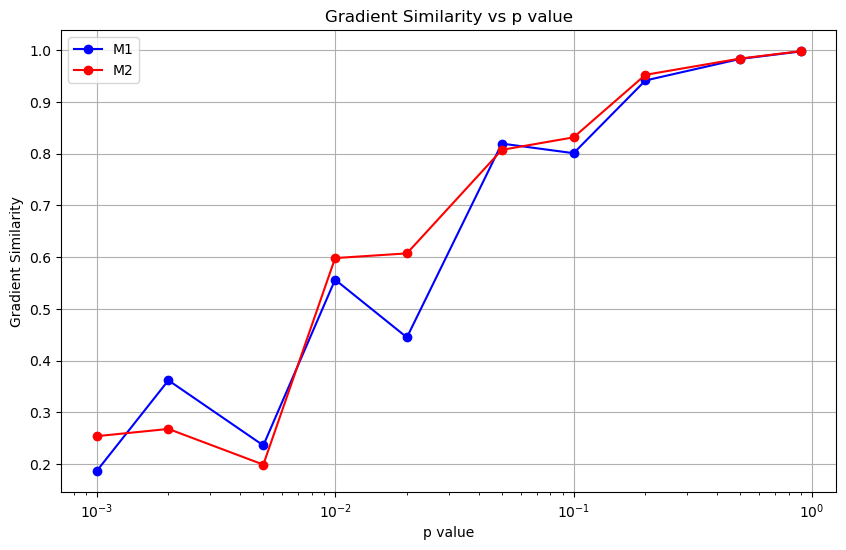

p = 0.001: M1 similarity = 0.1863, M2 similarity = 0.2538
p = 0.002: M1 similarity = 0.3618, M2 similarity = 0.2679
p = 0.005: M1 similarity = 0.2360, M2 similarity = 0.1988
p = 0.010: M1 similarity = 0.5565, M2 similarity = 0.5983
p = 0.020: M1 similarity = 0.4449, M2 similarity = 0.6074
p = 0.050: M1 similarity = 0.8197, M2 similarity = 0.8075
p = 0.100: M1 similarity = 0.8011, M2 similarity = 0.8318
p = 0.200: M1 similarity = 0.9417, M2 similarity = 0.9527
p = 0.500: M1 similarity = 0.9835, M2 similarity = 0.9842
p = 0.900: M1 similarity = 0.9981, M2 similarity = 0.9985


In [10]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from models import MNISTNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def gray_to_rgb(img):
    return img.repeat(3, 1, 1)

def load_mnist_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(gray_to_rgb),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    return trainset

def random_sample_mnist(trainset, exclude_classes):
    indices = []
    labels = []
    for i, (_, label) in enumerate(trainset):
        if label not in exclude_classes:
            indices.append(i)
            labels.append(label)
    
    sampled_data = torch.stack([trainset[i][0] for i in indices])
    sampled_labels = torch.tensor(labels)
    
    return sampled_data, sampled_labels

def get_gradients(X, y, model, criterion):
    model.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y).mean()
    loss.backward()

    grad_list = []
    for name, p in model.named_parameters():
        if p.grad is not None:
            grad_list.append(p.grad.detach().cpu().numpy().flatten())

    return np.concatenate(grad_list)

def calculate_gradient_similarity(model, memory_x, memory_y, full_x, full_y, criterion):
    memory_grad = get_gradients(memory_x, memory_y, model, criterion)
    full_grad = get_gradients(full_x, full_y, model, criterion)
    
    similarity = np.dot(memory_grad, full_grad) / (np.linalg.norm(memory_grad) * np.linalg.norm(full_grad))
    return similarity

# Load MNIST data
trainset = load_mnist_data()

# Randomly sample MNIST data, excluding classes 8 and 9
full_x, full_y = random_sample_mnist(trainset, exclude_classes=[8, 9])
full_x, full_y = full_x.to(device), full_y.to(device)

# Load pre-trained M1 and M2 models
model_1 = MNISTNet().to(device)
model_2 = MNISTNet().to(device)
model_1.load_state_dict(torch.load('ideal_models_M1.pth'))
model_2.load_state_dict(torch.load('ideal_models_M2.pth'))

criterion = nn.CrossEntropyLoss(reduction='none')

# Define p values
p_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.9]

similarities_1 = []
similarities_2 = []

for p in p_values:
    memory_size = int(p * len(full_x))
    indices = torch.randperm(len(full_x))[:memory_size]
    memory_x = full_x[indices]
    memory_y = full_y[indices]
    
    sim_1 = calculate_gradient_similarity(model_1, memory_x, memory_y, full_x, full_y, criterion)
    sim_2 = calculate_gradient_similarity(model_2, memory_x, memory_y, full_x, full_y, criterion)
    
    similarities_1.append(sim_1)
    similarities_2.append(sim_2)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(p_values, similarities_1, 'b-o', label='M1')
plt.plot(p_values, similarities_2, 'r-o', label='M2')
plt.xscale('log')
plt.xlabel('p value')
plt.ylabel('Gradient Similarity')
plt.title('Gradient Similarity vs p value')
plt.legend()
plt.grid(True)
plt.savefig('gradient_similarity_vs_p.png')
plt.show()

# Print results
for p, sim_1, sim_2 in zip(p_values, similarities_1, similarities_2):
    print(f"p = {p:.3f}: M1 similarity = {sim_1:.4f}, M2 similarity = {sim_2:.4f}")